The purpose is to create a machine learning model that can predict the number of Jets in CERN's [Proton Collision Dataset](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset), which is stored in `CERN_Proton_Collision.zip`. I use TensorFlow to accomplish this.

MultiJet primary dataset in AOD format from RunB of 2010. This dataset contains runs from 2010 RunB. The list of all validated runs, which must be applied to all analyses, can be found in [http://opendata.cern.ch/record/1000](http://opendata.cern.ch/record/1000).
This file contains events from the MultiJet primary dataset from the CMS open data release, and computes the razor variables MR and Rsq, used in supersymmetric particle searches. More details on the razor variables can be found in Phys. Rev. D 90, 112001 [(https://journals.aps.org/prd/pdf/10.1103/PhysRevD.90.112001)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.90.112001)

Content:

1) Run: The run number of the event.

2) Lumi: The lumi section of the event.

3) Event: The event number of the event.

4) MR: First razor kinematic variable, the MR variable is an estimate of an overall mass scale, which in the limit of massless decay products equals the mass of the heavy parent particle.

5) Rsq: Second razor kinematic variable, the Rsq variable is the square of the ratio R, which quantifies the flow of energy in the plane perpendicular to the beam and the partitioning of momentum between visible and invisible particles.

6,7,8,9) E1,Px1,Py1,Pz1: The four-vector of the leading megajet (with the largest transverse momentum).

10,11,12,13) E2,Px2,Py2,Pz2: The four-vector of the subleading megajet (with the largest transverse momentum).

14) HT: The scalar sum of the transverse momentum of the jets.

15) MET: The magnitude of the vector sum of the transverse energy of the particles in the event.

16) nJets: The number of jets with transverse momentum above 40 GeV.

17) nBJets: The number of b-tagged jets with transverse momentum above 40 GeV.


Source: [Kaggle](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset)

In [ ]:
#Import libraries
import numpy as np
import scipy.optimize as opt
import re, seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

# Read data using pandas

In [ ]:
df = pd.read_csv("CERN_Proton_Collision.zip") 
df.head() 

Run  Lumi      Event       MR       Rsq        E1      Px1        Py1  \
0  148029   388  302318745  215.553  0.031977  136.7100 -109.893  -54.03420   
1  148029   388  302323641  155.437  0.042157   83.3865   81.150    6.88361   
2  148029   388  302336217  400.563  0.026938  253.1840  139.902  102.64000   
3  148029   388  302382289  286.245  0.094192  175.4860 -156.024  -62.95350   
4  148029   388  302403873  204.514  0.018804  833.7950  100.410  -16.65900   

        Pz1        E2       Px2       Py2       Pz2       HT       MET  nJets  \
0  -58.9032  142.1790   70.0254  41.12250 -116.5130  203.666  18.31100      2   
1  -12.9688   73.9025  -72.2472  11.88350    3.0899  154.659  14.77470      2   
2 -101.9350  535.5510 -110.3790 -89.09290 -516.1790  343.280  25.22110      3   
3  -47.7434  112.8510   89.0843   3.45025   67.9007  257.397  46.02880      2   
4 -827.4980  445.6120  -91.1991  15.55830 -390.1440  269.492   8.11345      3   

   nBJets  
0       0  
1       0  
2       0  
3       0  
4       0

# I need to know what type of data I am working with before I can work with dataframe, so I check it using the `dtypes`.

In [ ]:
df.dtypes

Run         int64
Lumi        int64
Event       int64
MR        float64
Rsq       float64
E1        float64
Px1       float64
Py1       float64
Pz1       float64
E2        float64
Px2       float64
Py2       float64
Pz2       float64
HT        float64
MET       float64
nJets       int64
nBJets      int64
dtype: object

**In the dataframe, there are 21726 records with 17 columns.**

In [ ]:
df.shape

(21726, 17)

**I am going to test if there are NaN values in dataframe**

In [ ]:
df.isnull().any().any()

False

**There are no NaN values**

**I want to know how many of each type of Jet are in the data frame, so I create a histogram and pie chart. Before that, I create a data frame containing a number of jets, as follows:**

In [ ]:
d = {'nJets': ['2 Jets','3 Jets','4 Jets','5 Jets','6 Jets','7 Jets'], 'Numberr of Jets': [14002, 6204, 1325, 169, 23, 3]} 
dfC = pd.DataFrame(data=d)
dfC

nJets  Numberr of Jets
0  2 Jets            14002
1  3 Jets             6204
2  4 Jets             1325
3  5 Jets              169
4  6 Jets               23
5  7 Jets                3

# Jet histogram

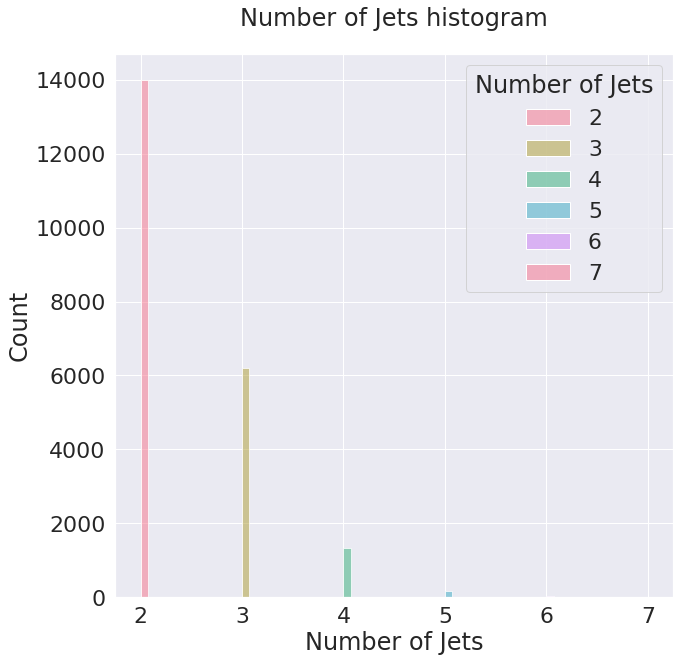

In [ ]:
df1 = df
df1 = df1.rename(columns={'nJets': 'Number of Jets'}) 
plt.figure(figsize=(10, 10))
sns.set(font_scale=2.0)
plt.title("Number of Jets histogram", y=1.04) 
sns.histplot(data=df1, x="Number of Jets", hue="Number of Jets", palette="husl")

# Pie chart

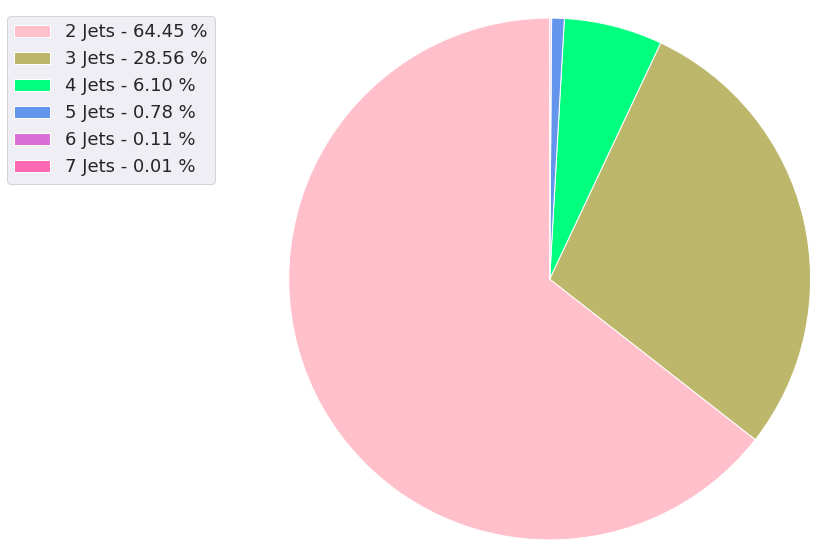

In [ ]:
plt.figure(figsize=(10, 10))
x = np.char.array(['2 Jets','3 Jets','4 Jets','5 Jets','6 Jets','7 Jets'])
y = np.array([14002, 6204, 1325, 169, 23, 3])
colors = ['pink','darkkhaki','springgreen','cornflowerblue','orchid','hotpink']
percent = 100.*y/y.sum()
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                           key=lambda x: x[2],
                                           reverse=True))
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
            fontsize=18)

plt.savefig('piechart.png', bbox_inches='tight')

**Pie chart and histograms show that 5, 6, and 7 Jets have a small percentage of the data frame.**

# Descriptive statistics:

In [ ]:
df.describe()

Run          Lumi         Event            MR           Rsq  \
count   21726.000000  21726.000000  2.172600e+04  21726.000000  21726.000000   
mean   148666.049710    900.693501  8.635646e+08    351.981435      0.023253   
std       596.085618    496.482684  4.786516e+08    193.691363      0.023291   
min    147926.000000    388.000000  3.023155e+08     29.999900      0.000009   
25%    148029.000000    463.000000  4.976106e+08    229.790750      0.007907   
50%    149181.000000    986.000000  9.709389e+08    292.911000      0.016817   
75%    149181.000000    999.000000  9.844834e+08    406.883000      0.031612   
max    149181.000000   1804.000000  1.703645e+09   2433.820000      0.763695   

                 E1           Px1           Py1           Pz1            E2  \
count  21726.000000  21726.000000  21726.000000  21726.000000  21726.000000   
mean     297.178955      0.283289      0.764211     -8.523257    277.410117   
std      224.040020     91.701247     90.770124    341.366770    206.890743   
min       44.947600   -543.821000   -648.385000  -2022.310000     42.048600   
25%      143.531000    -78.472975    -75.770000   -151.347750    126.916250   
50%      212.060500     -0.310509      1.238670     -5.478110    204.140000   
75%      374.542750     78.562475     77.738075    135.345250    366.710500   
max     2101.580000    722.291000    470.234000   2061.890000   1843.360000   

                Px2           Py2           Pz2            HT           MET  \
count  21726.000000  21726.000000  21726.000000  21726.000000  21726.000000   
mean      -0.399385     -0.909938     -1.915512    242.328342     16.005371   
std       76.720135     75.758491    321.415092     78.841528     10.797882   
min     -700.112000   -459.801000  -1647.600000    120.938000      0.100445   
25%      -63.333250    -62.706450   -154.231750    193.252000      8.626845   
50%       -0.548208     -1.900460     -1.803295    223.696000     14.035000   
75%       62.852025     61.111550    151.167750    269.241500     21.091050   
max      405.326000    635.734000   1830.370000   1462.630000    423.144000   

              nJets        nBJets  
count  21726.000000  21726.000000  
mean       2.435791      0.053668  
std        0.655750      0.236334  
min        2.000000      0.000000  
25%        2.000000      0.000000  
50%        2.000000      0.000000  
75%        3.000000      0.000000  
max        7.000000      2.000000

# Boxplots and outliers

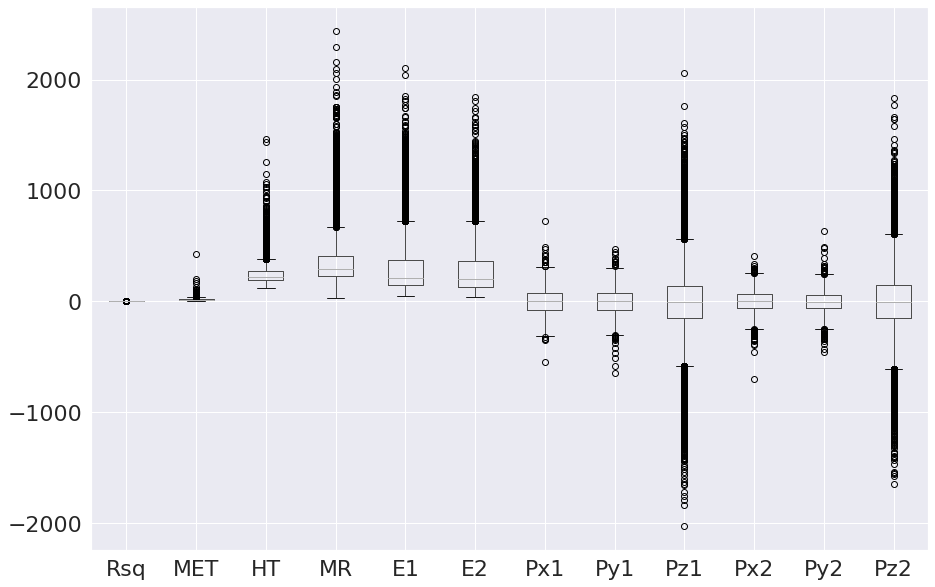

In [ ]:
plt.figure(figsize=(15, 10))
boxplot = df.boxplot(column=['Rsq', 'MET', 'HT', 'MR', 'E1', 'E2', 'Px1', 'Py1', 'Pz1', 'Px2', 'Py2', 'Pz2'])

I use the Seaborn `heatmap()` function to determine which features have the most impact on `nJets`.

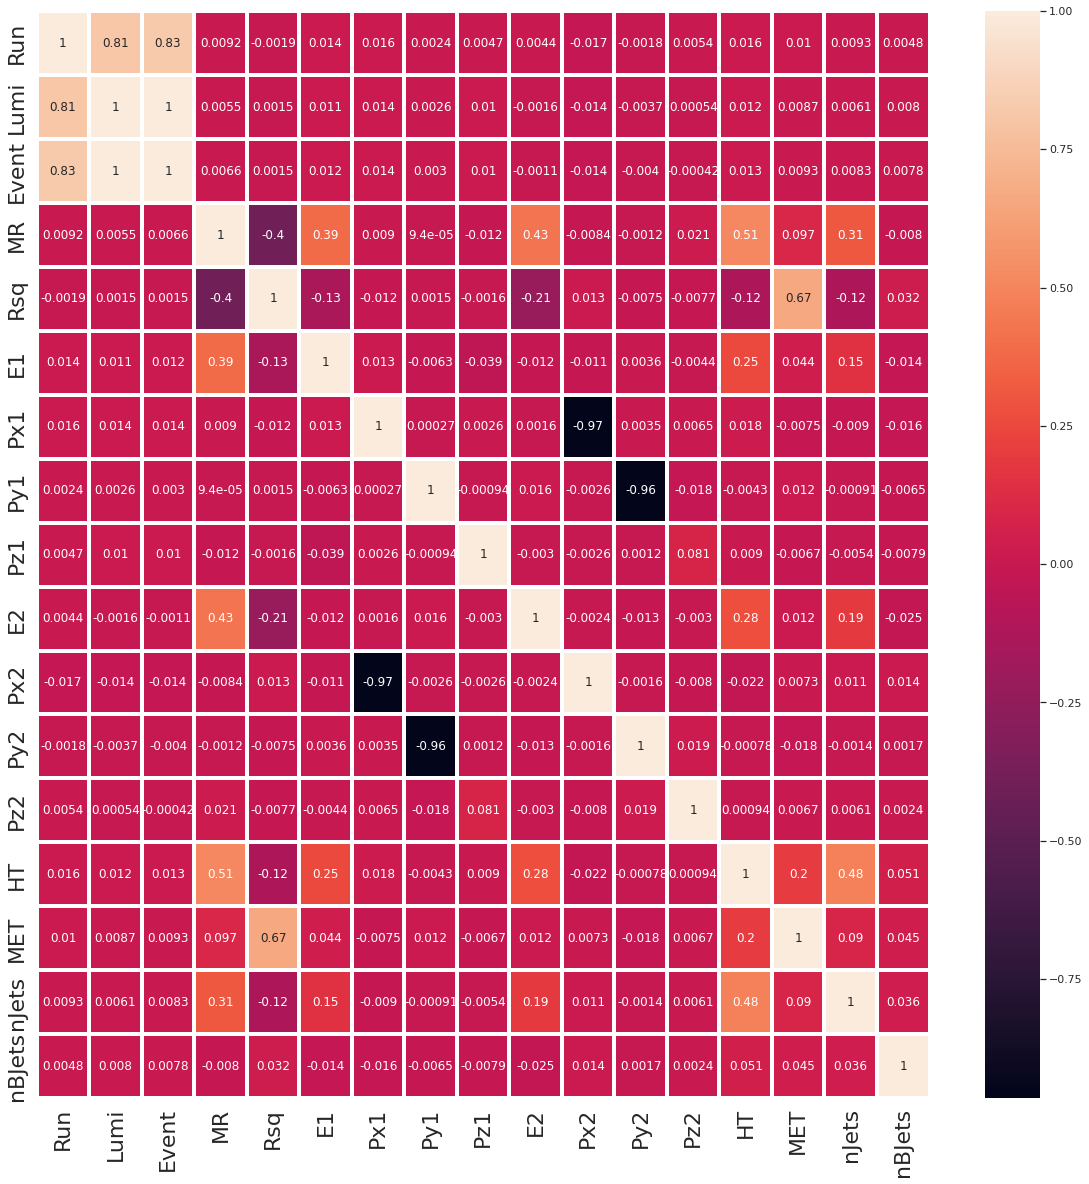

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.set(font_scale=1.0)
sns.heatmap(df.corr() , annot= True, linewidths=3, ax=ax)

# Number of Jets is greatly influenced by:

In [ ]:
d = {'Number of Jets is greatly influenced by:': ['HT', 'MR', 'E2', 'E1'], 'correlation coefficient': [0.48, 0.31, 0.19, 0.15]}
dfC = pd.DataFrame(data=d)
dfC

Number of Jets is greatly influenced by:  correlation coefficient
0                                       HT                     0.48
1                                       MR                     0.31
2                                       E2                     0.19
3                                       E1                     0.15

# Data Visualization and Analysis:

<Figure size 720x576 with 0 Axes>

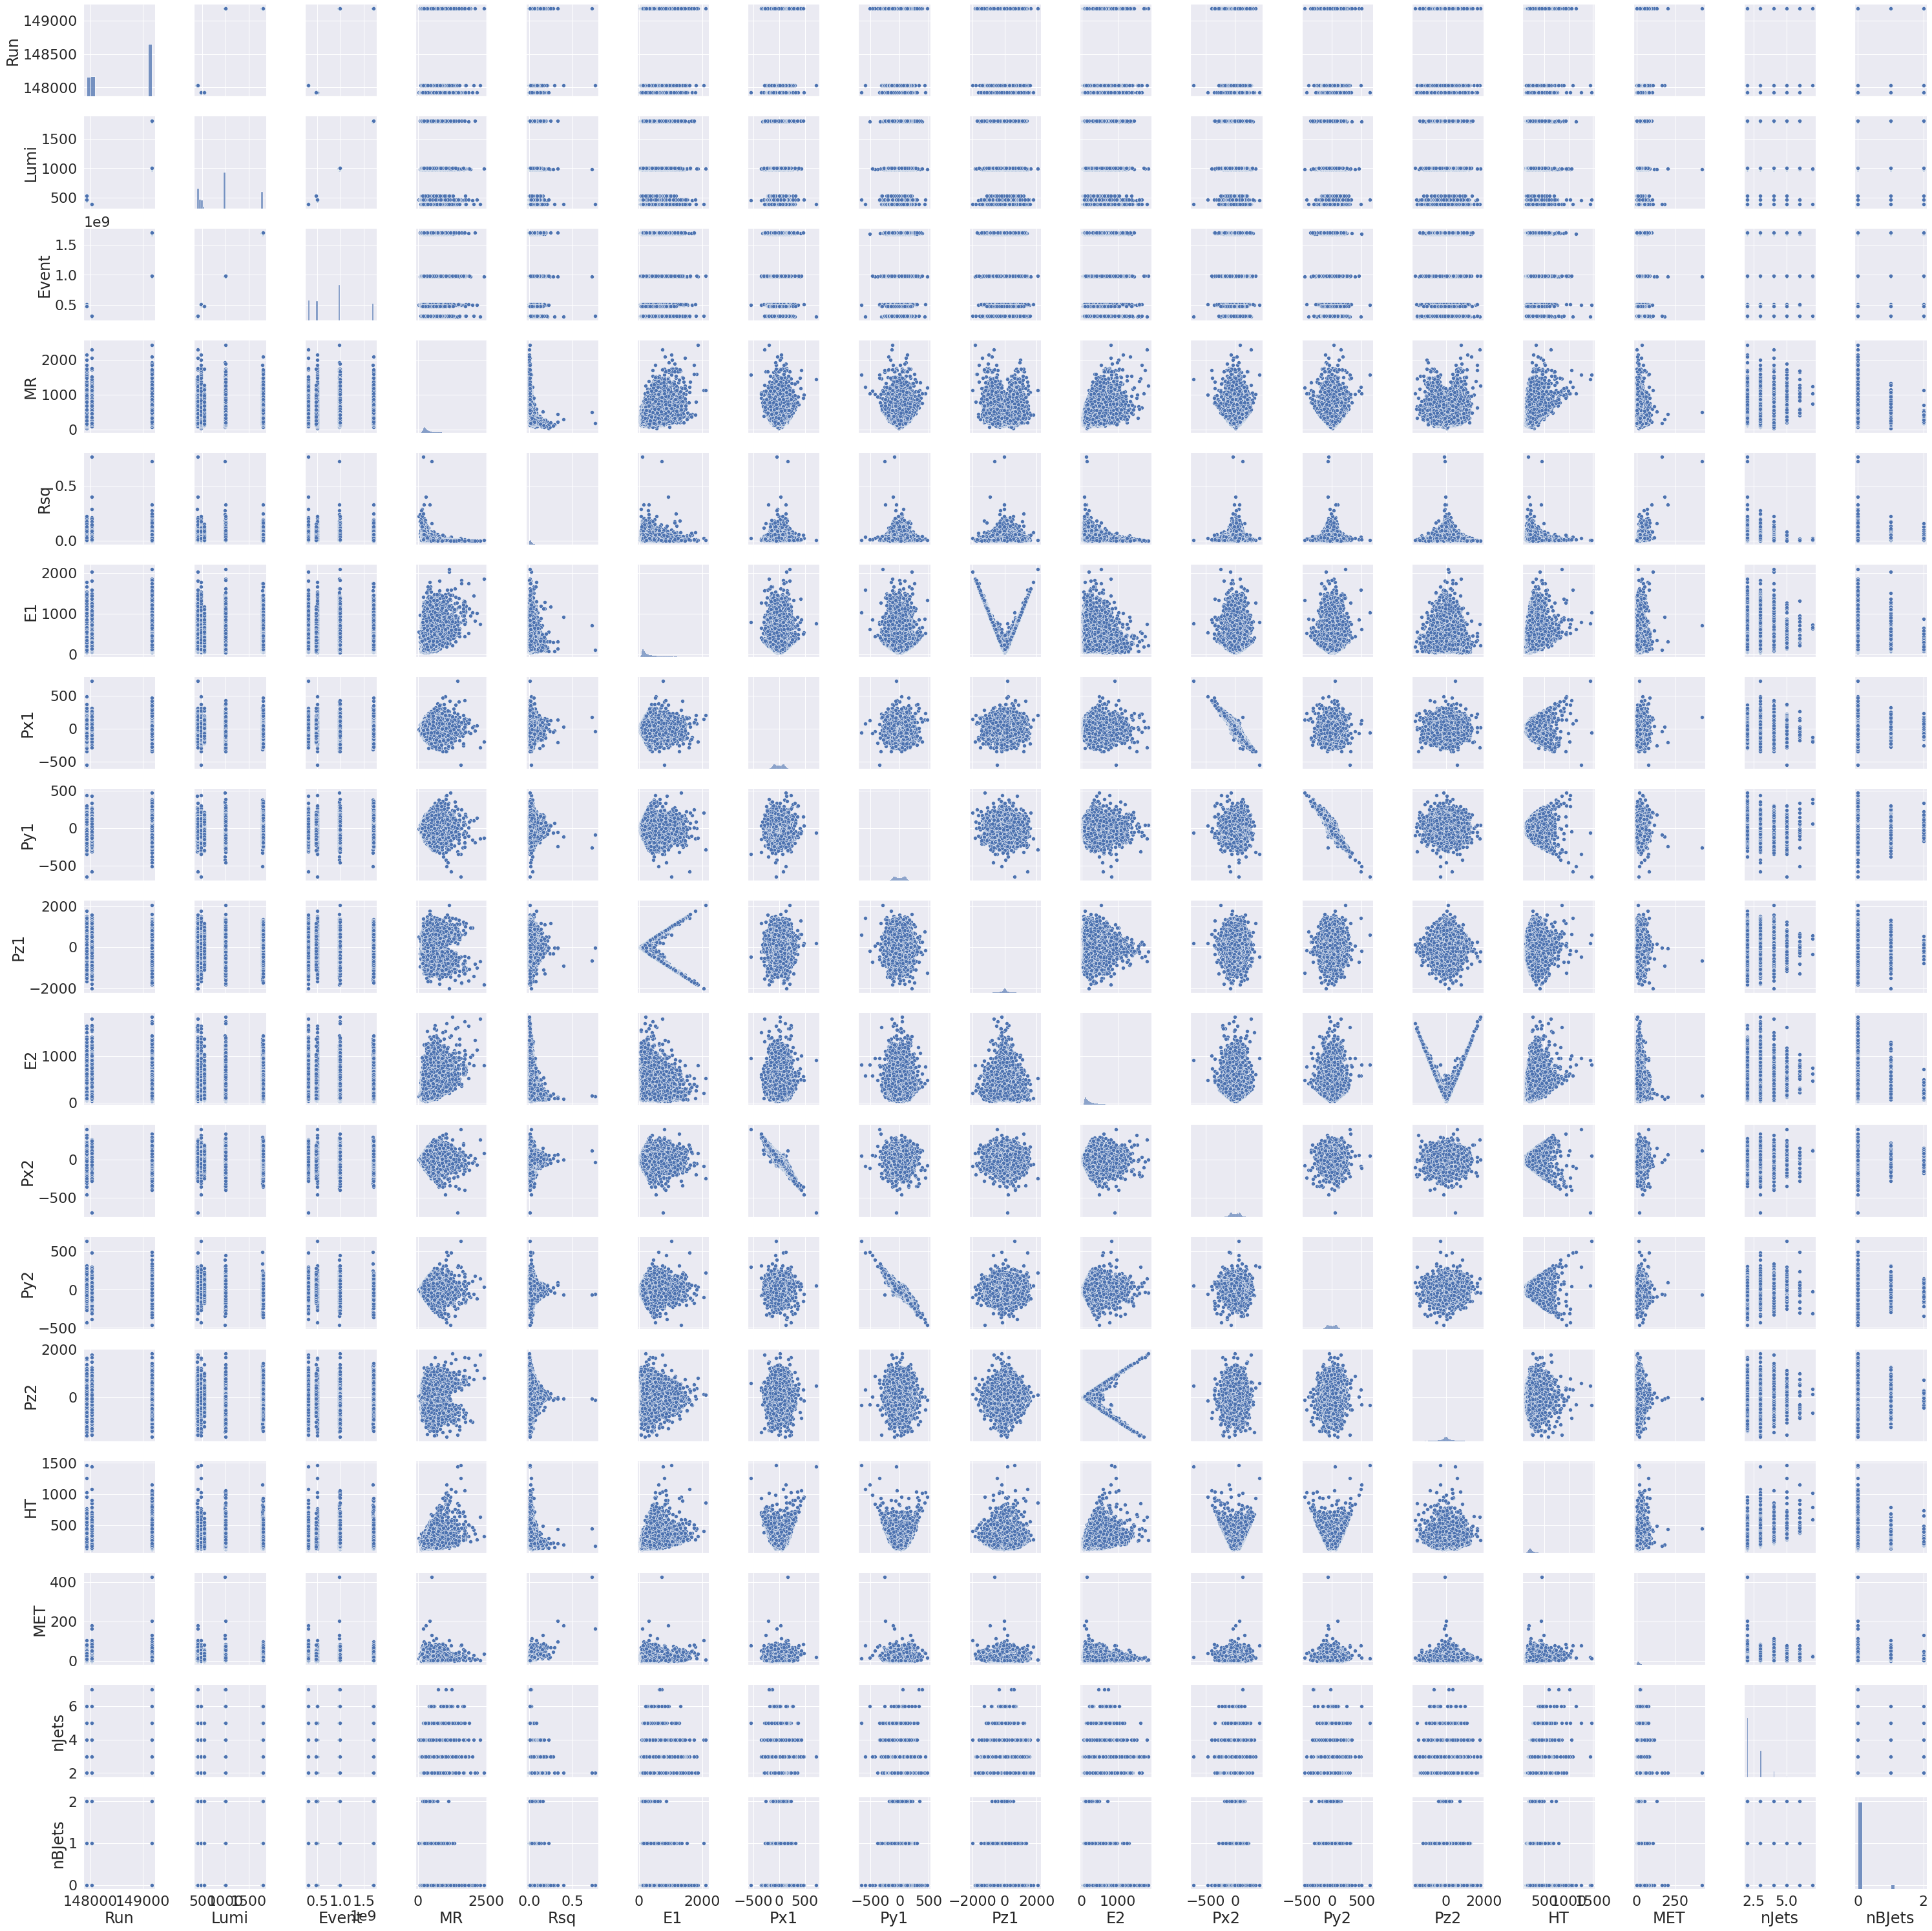

In [ ]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=2.0)
sns.pairplot(df)

**I would like to plot more details on some of these graphs in 2D and 3D.**

# Scatter plots in 2D

## 1. `E1` vs `Px1` 

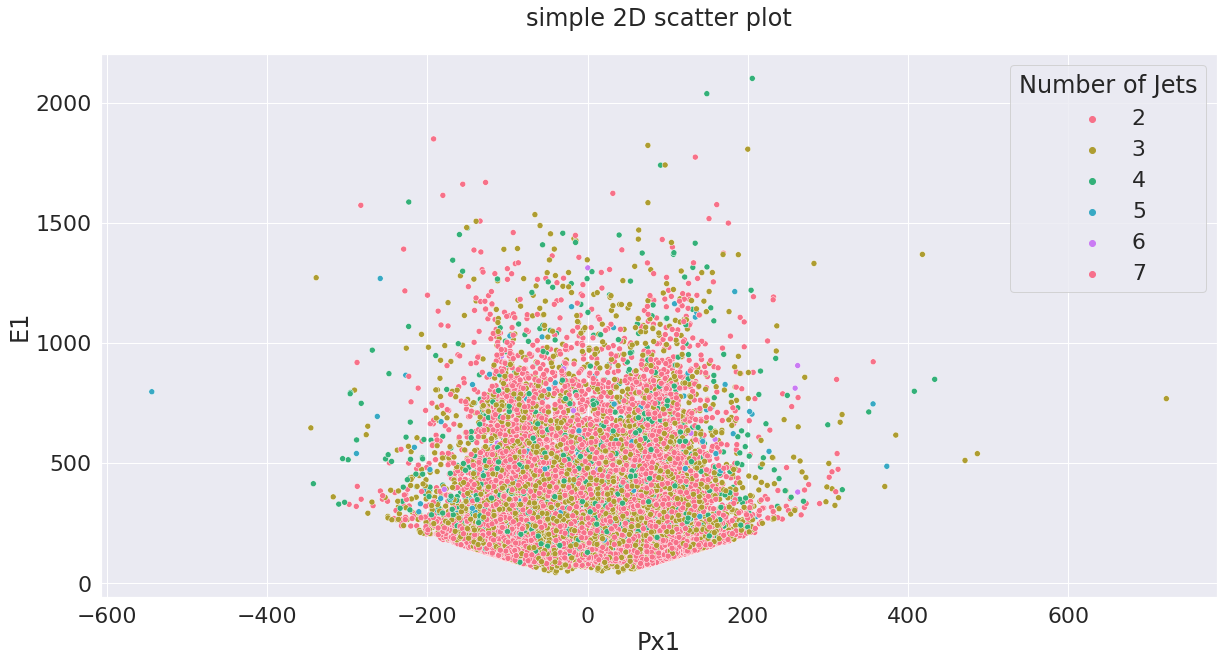

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='Px1', y='E1', hue='Number of Jets', palette="husl")

## 2. `MR` vs `Px1` 

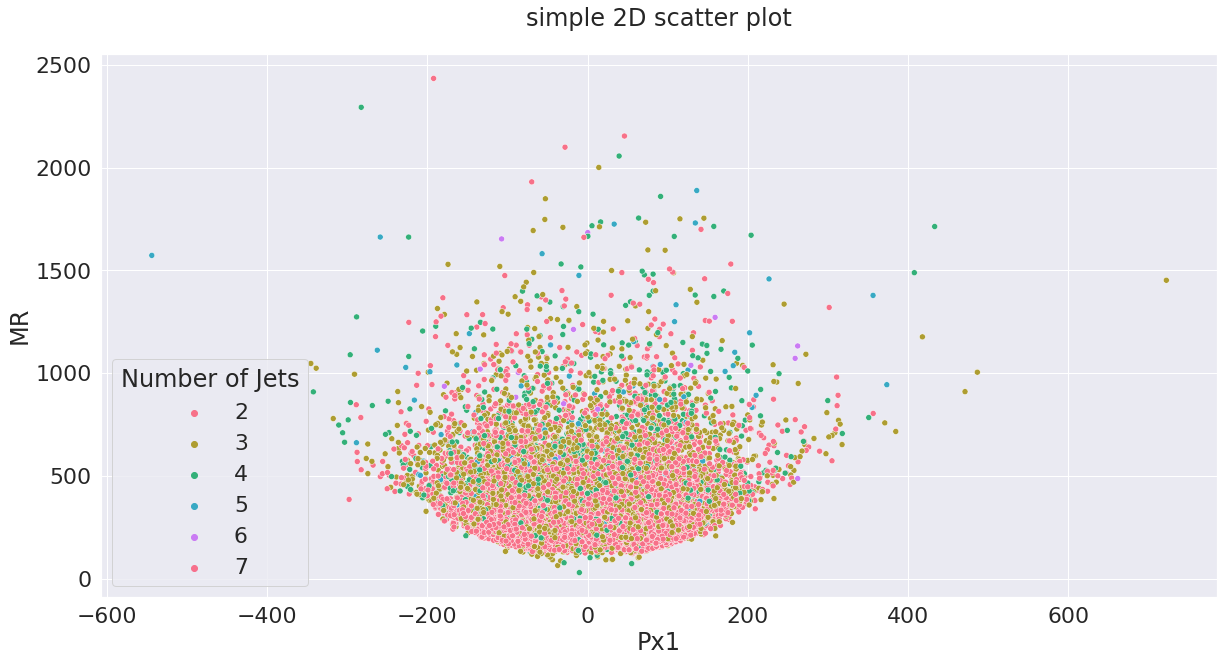

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='Px1', y='MR', hue='Number of Jets', palette="husl")

## 3. `Number of Jets` vs `E1` 

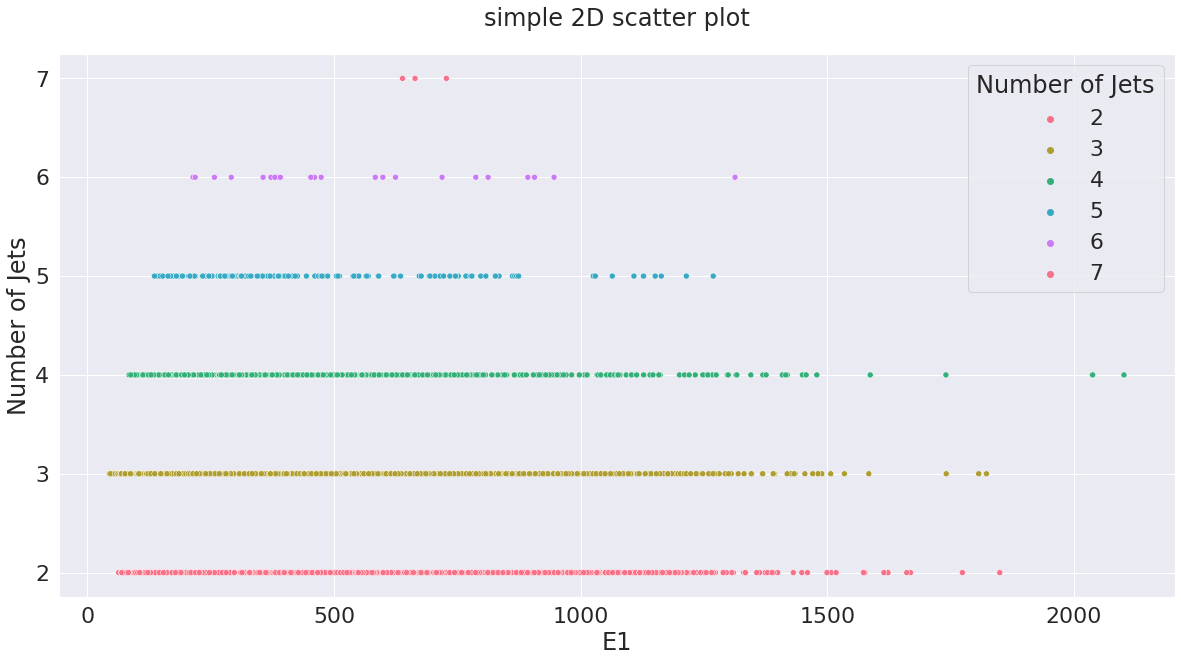

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='E1', y='Number of Jets', hue='Number of Jets', palette="husl")



*   The seven-jet phenomenon can only be spotted in 500 < E1 < 1000
*   The four-jet phenomenon is only a phenomenon that can be spotted in E1>2000



## 4. `HT` vs `MR` 

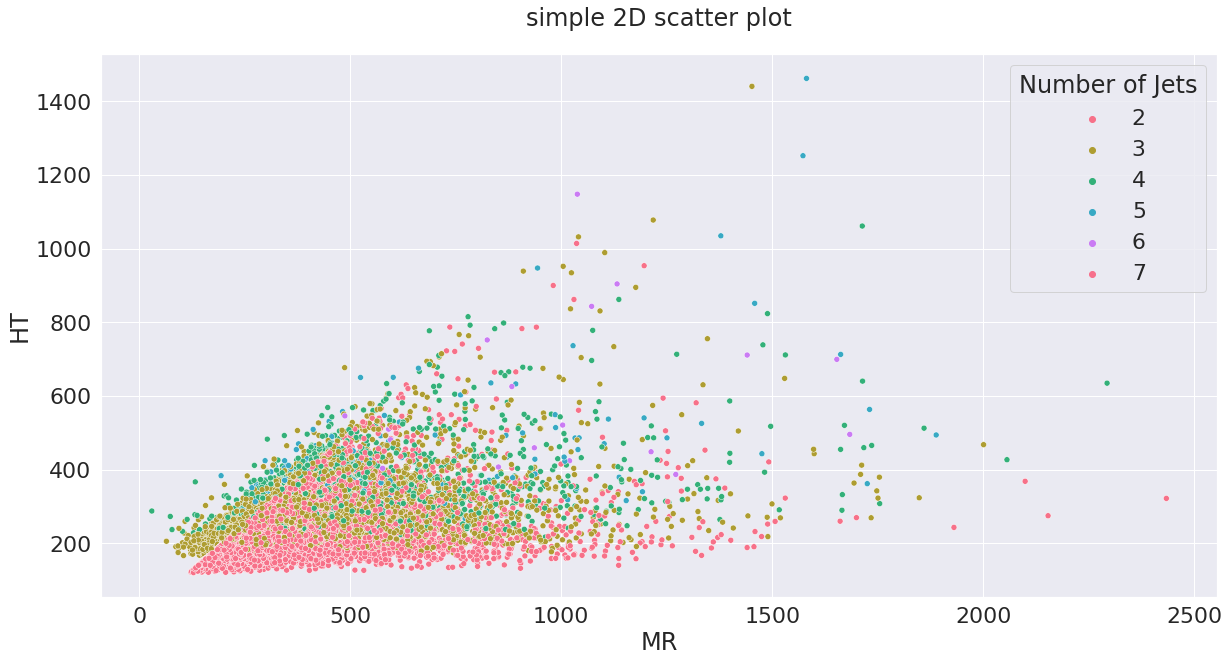

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='MR', y='HT', hue='Number of Jets', palette="husl")

## 4. `Py1` vs `Px1`

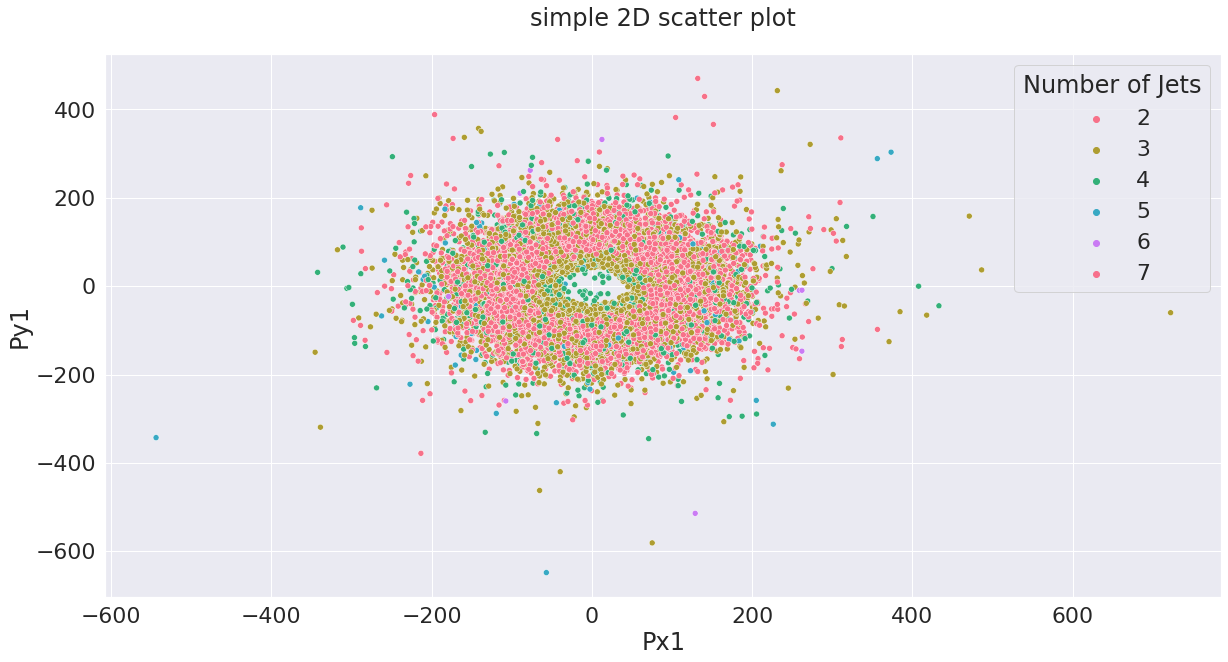

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='Px1', y='Py1', hue='Number of Jets', palette="husl")

## 5. `Px1` vs `HT`

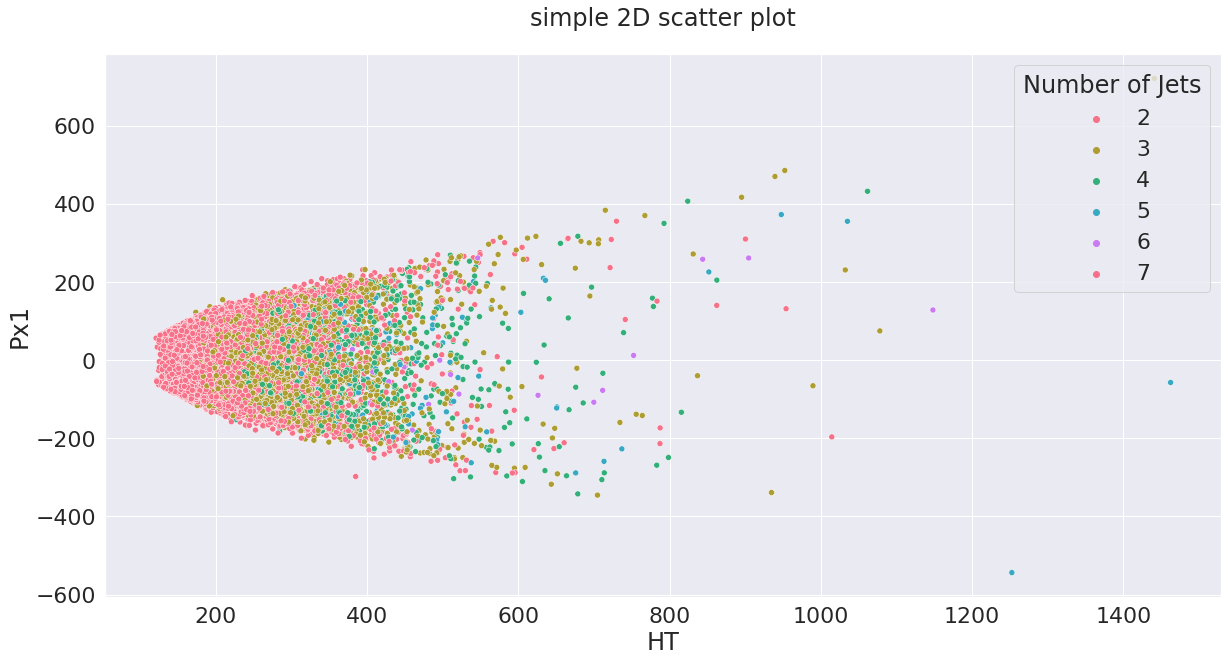

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='HT', y='Px1', hue='Number of Jets', palette="husl")

## 6. `Pz1` vs `HT`

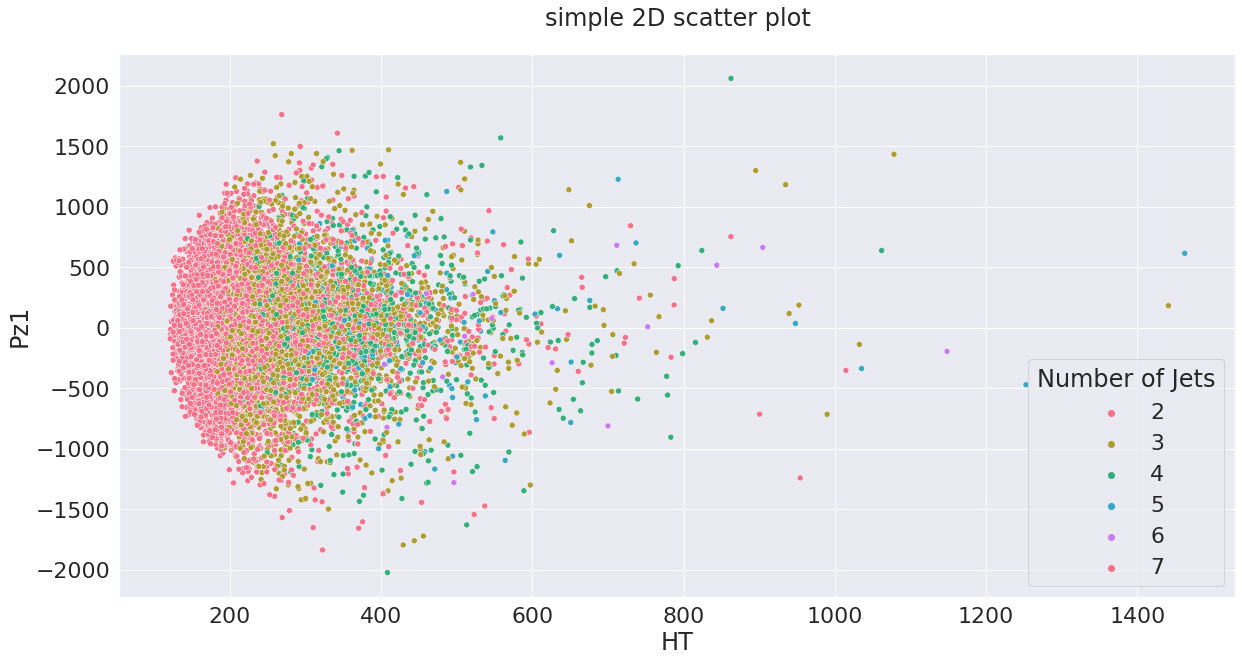

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='HT', y='Pz1', hue='Number of Jets', palette="husl")

## 7. `Rsq` vs `Pz1`

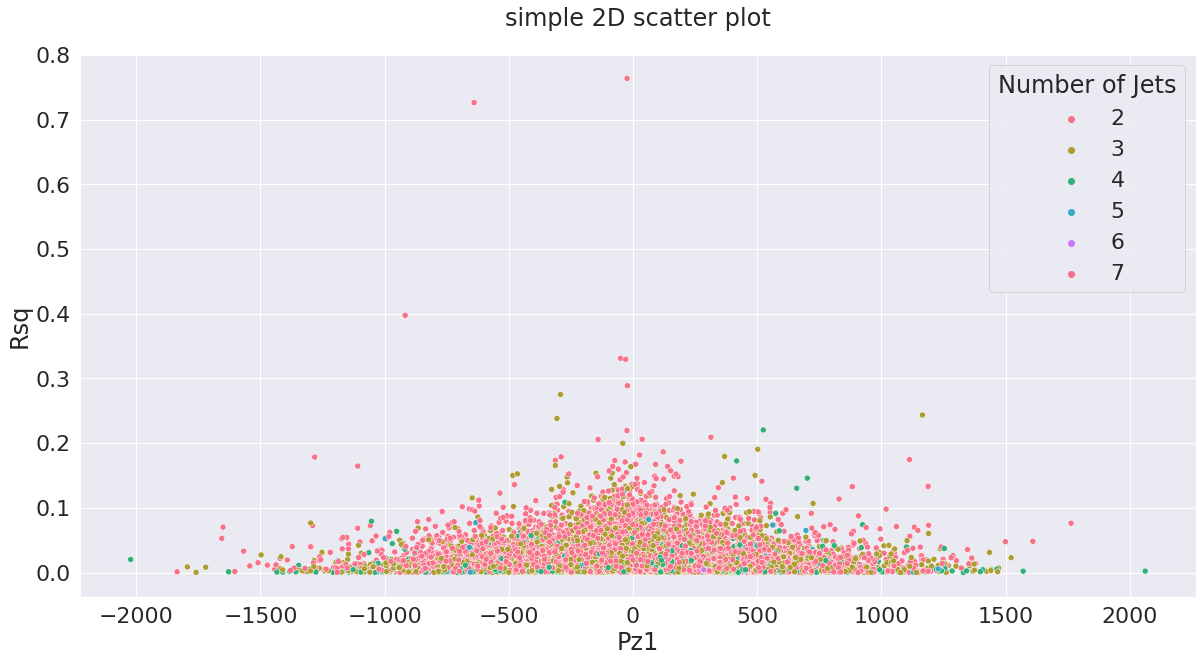

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='Pz1', y='Rsq', hue='Number of Jets', palette="husl")

## 8. `Pz1` vs `E1`

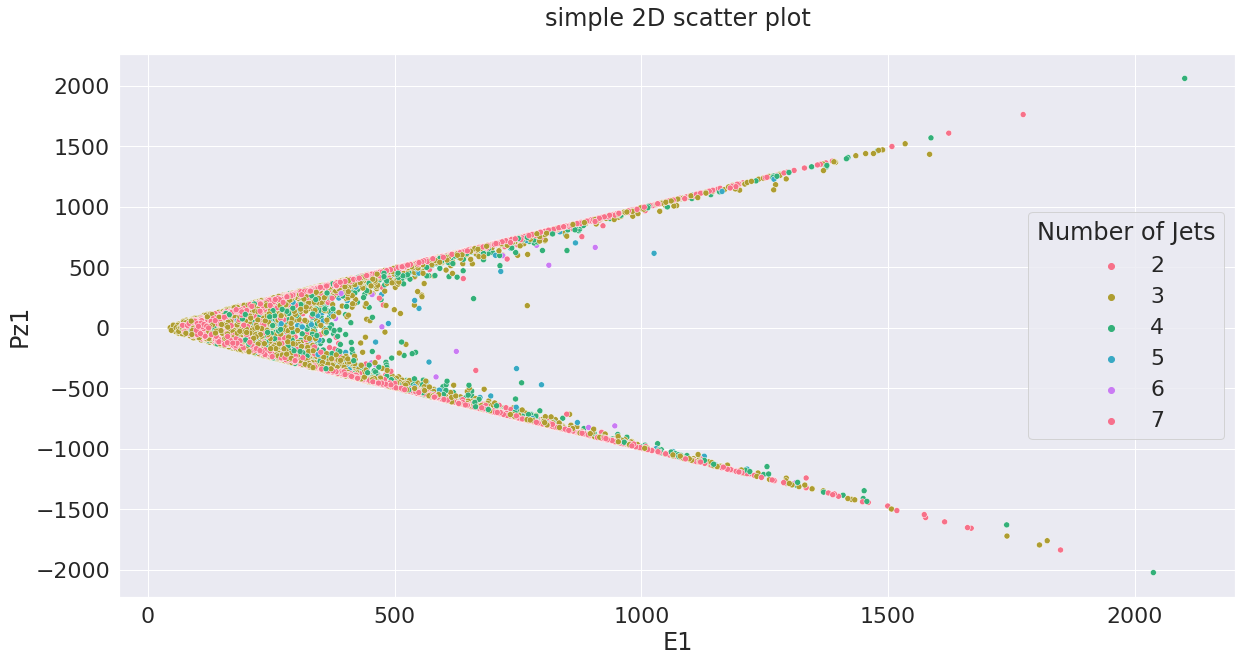

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='E1', y='Pz1', hue='Number of Jets', palette="husl")

## 9. `MR` vs `Pz1`

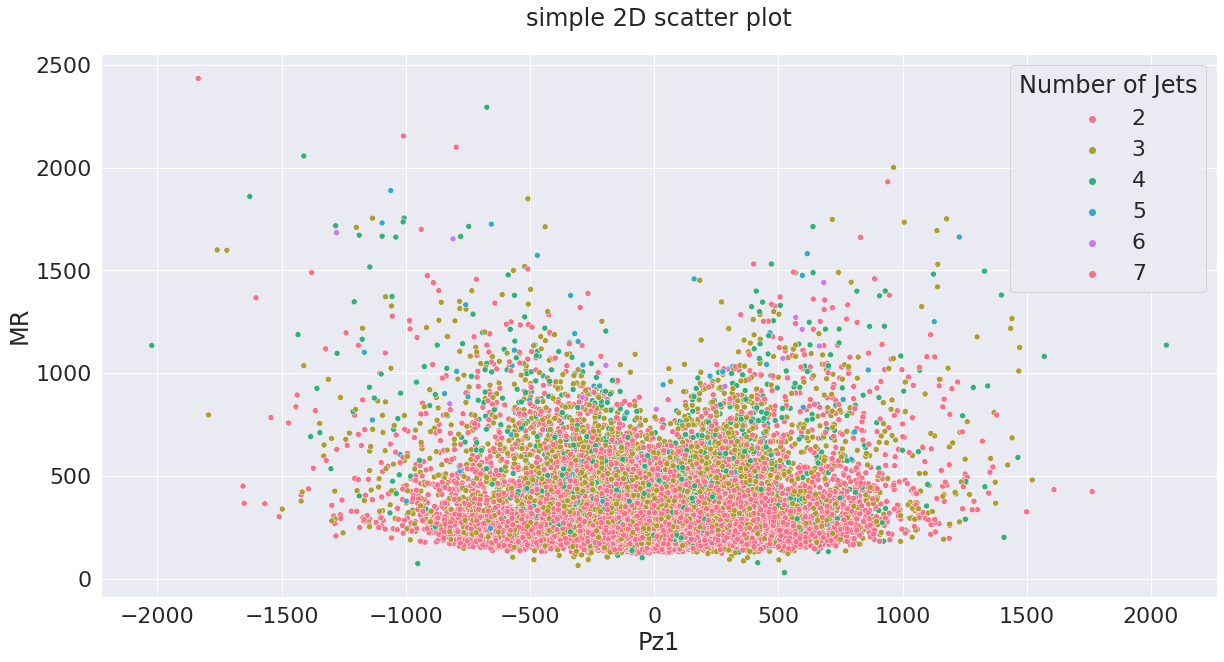

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
plt.title("simple 2D scatter plot", y=1.04)
sns.scatterplot(data=df1, x='Pz1', y='MR', hue='Number of Jets', palette="husl")

# 3D scatter plots

## 1. `E1` vs `Px1` vs `Py1`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


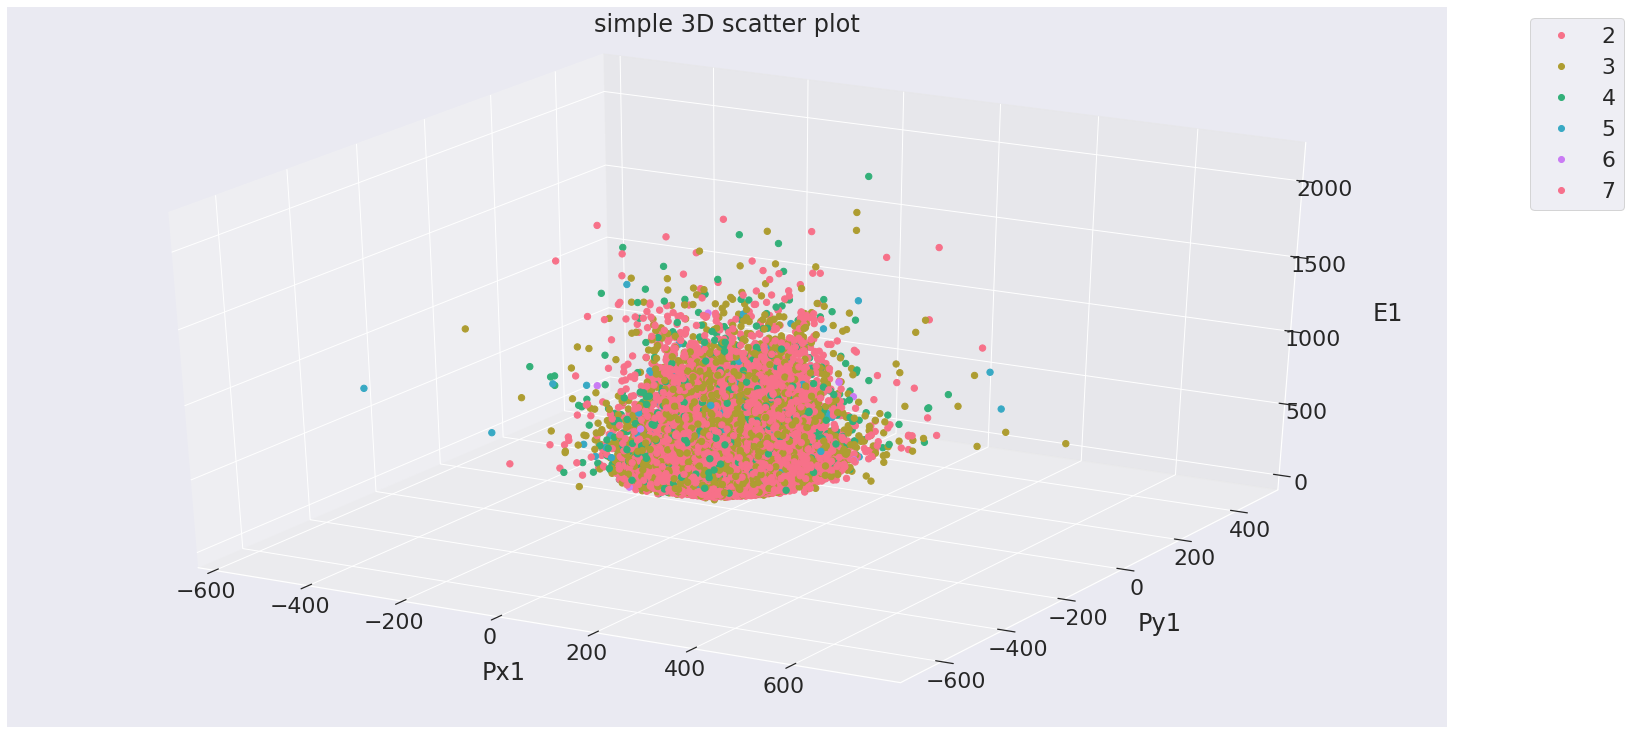

In [ ]:
# generate data
x = df['Px1']
y = df['Py1']
z = df['E1']  

# axes instance
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=df['nJets'], marker='o', cmap=cmap, alpha=1)

plt.title("simple 3D scatter plot", y=1.04)

ax.set_xlabel('Px1')
ax.set_xlabel('Px1', labelpad=30)

ax.set_ylabel('Py1')
ax.set_ylabel('Py1', labelpad=30)

ax.set_zlabel('E1')
ax.set_zlabel('E1', labelpad=30)

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

## 2. `MR` vs `Px1` vs `Py1`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


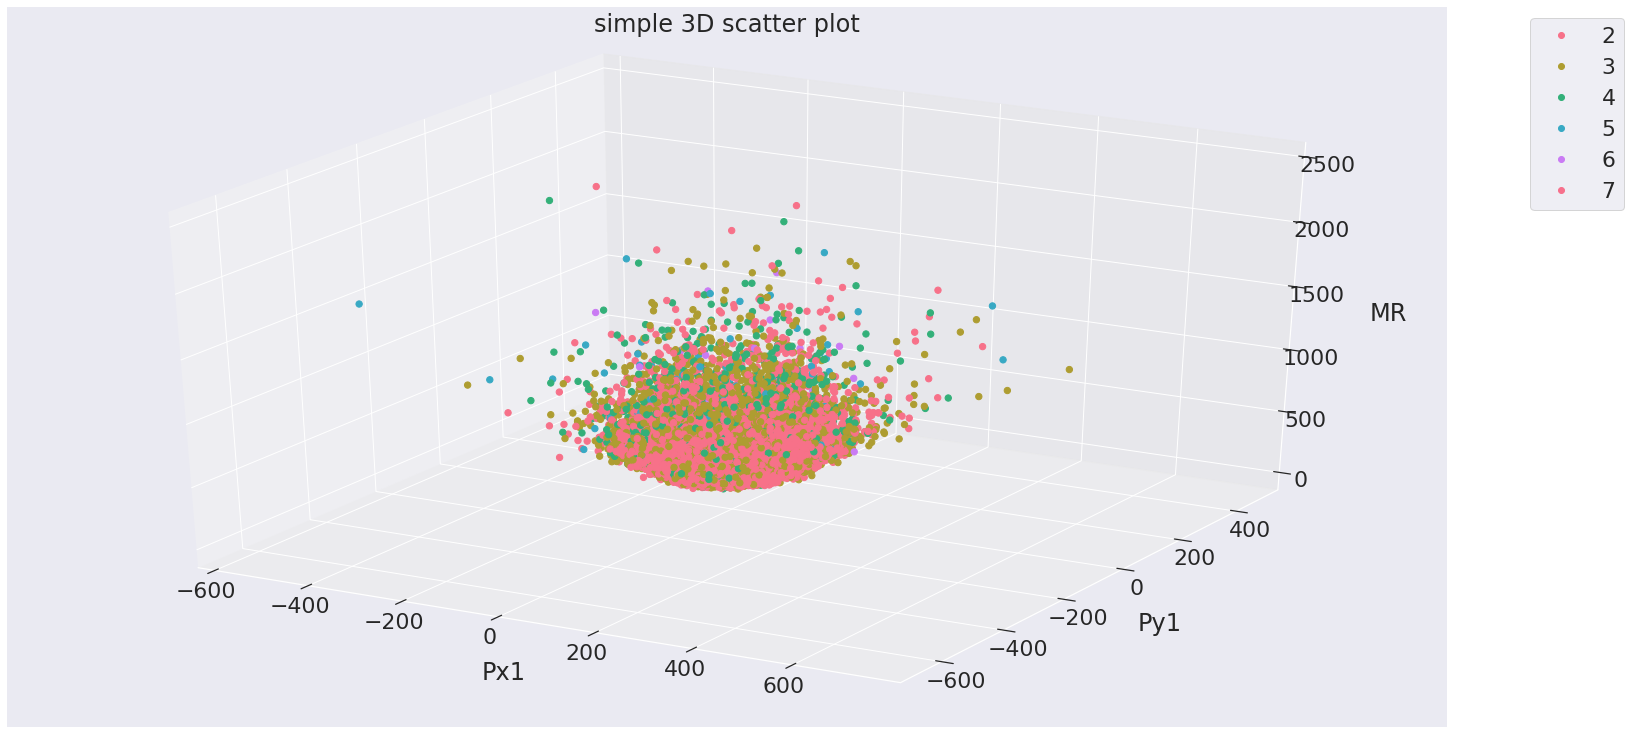

In [ ]:
# generate data
x = df['Px1']
y = df['Py1']
z = df['MR']  

# axes instance
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=df['nJets'], marker='o', cmap=cmap, alpha=1)

plt.title("simple 3D scatter plot", y=1.04)

ax.set_xlabel('Px1')
ax.set_xlabel('Px1', labelpad=30)

ax.set_ylabel('Py1')
ax.set_ylabel('Py1', labelpad=30)

ax.set_zlabel('MR')
ax.set_zlabel('MR', labelpad=30)

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

## 3. `Px1` vs `Py1` vs `Pz1`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


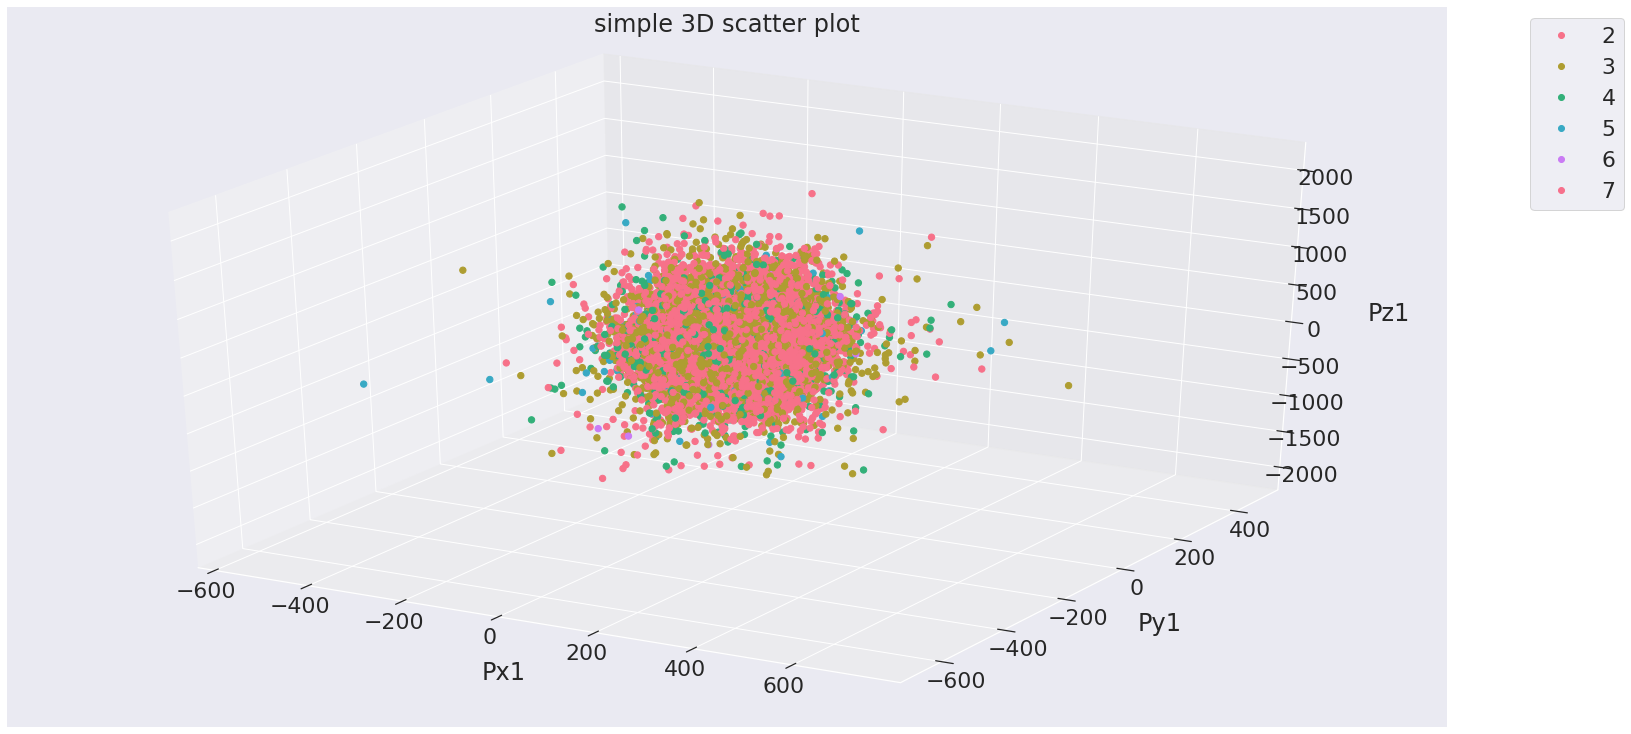

In [ ]:
# generate data
x = df['Px1']
y = df['Py1']
z = df['Pz1']  

# axes instance
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=df['nJets'], marker='o', cmap=cmap, alpha=1)

plt.title("simple 3D scatter plot", y=1.04)

ax.set_xlabel('Px1')
ax.set_xlabel('Px1', labelpad=30)

ax.set_ylabel('Py1')
ax.set_ylabel('Py1', labelpad=30)

ax.set_zlabel('Pz1')
ax.set_zlabel('Pz1', labelpad=30)

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

# The next step is to create a model to predict the number of Jets using TensorFlow.

## I first split the DataFrame into X (data) and Y (labels), where:

In [ ]:
df.nJets = df.nJets.map({2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5}) 
X = df.drop(['nJets'], axis=1)
y = df['nJets']  

## Using a train-test split, I split X and Y into train and test data.

*   Train Dataset: Used to fit model.
*   Test Dataset: Used to evaluate the fit model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## TensorFlow

The first thing I do is train a simple Neural Network using TensorFlow, and then plot accuracy and loss graphs on the training and validation datasets to find a balance between the model that is underfitting and one that is overfitting, resulting in a model with a good fit. I first need to convert the train and test data into a TensorFlow tensor. 

### To convert DataFrame to a tensor, I use `tf.convert_to_tensor`

In [ ]:
tf.convert_to_tensor(X_train)

<tf.Tensor: shape=(17380, 16), dtype=float64, numpy=
array([[1.49181000e+05, 1.78900000e+03, 1.69174702e+09, ...,
        2.03114000e+02, 3.19493000e+01, 0.00000000e+00],
       [1.49181000e+05, 1.78900000e+03, 1.69145596e+09, ...,
        2.63641000e+02, 2.26033000e+01, 0.00000000e+00],
       [1.49181000e+05, 9.98000000e+02, 9.83597837e+08, ...,
        2.45781000e+02, 7.92845000e+00, 0.00000000e+00],
       ...,
       [1.47926000e+05, 4.62000000e+02, 4.98088038e+08, ...,
        1.92466000e+02, 6.30772000e+00, 0.00000000e+00],
       [1.48029000e+05, 3.89000000e+02, 3.03389516e+08, ...,
        2.12675000e+02, 2.12651000e+00, 0.00000000e+00],
       [1.49181000e+05, 9.99000000e+02, 9.84587251e+08, ...,
        3.00290000e+02, 2.97415000e+01, 0.00000000e+00]])>

In [ ]:
tf.convert_to_tensor(X_test)

<tf.Tensor: shape=(4346, 16), dtype=float64, numpy=
array([[1.49181000e+05, 9.97000000e+02, 9.81749868e+08, ...,
        2.90486000e+02, 1.44300000e+01, 1.00000000e+00],
       [1.47926000e+05, 4.62000000e+02, 4.98113369e+08, ...,
        4.01390000e+02, 2.13951000e+01, 0.00000000e+00],
       [1.49181000e+05, 9.98000000e+02, 9.83048402e+08, ...,
        7.05866000e+02, 3.01095000e+01, 0.00000000e+00],
       ...,
       [1.49181000e+05, 9.86000000e+02, 9.71262564e+08, ...,
        1.81506000e+02, 1.81312000e+01, 0.00000000e+00],
       [1.49181000e+05, 9.86000000e+02, 9.71122660e+08, ...,
        1.75923000e+02, 2.72315000e+01, 0.00000000e+00],
       [1.47926000e+05, 4.63000000e+02, 4.98614290e+08, ...,
        2.08791000e+02, 1.53762000e+01, 0.00000000e+00]])>

### Normalize X_train, X_test

In [ ]:
X_train_scaled = tf.keras.layers.Normalization(axis=-1)
X_train_scaled.adapt(X_train)

In [ ]:
X_test_scaled = tf.keras.layers.Normalization(axis=-1)
X_test_scaled.adapt(X_test) 

### Building a simple neural network model

The compile function takes three arguments: optimizer, loss, and metrics.


*   **Optimizer**: These are certain algorithms that are used to change the attributes of the neural network to decrease the loss rate.
*   **Loss**: This is used to compute the quantity that a model should seek to minimize during training.


*   **Metrics**: This is used to judge the performance of the model.





## Model 1: There are two hidden layers, each with 16 neurons and an activation function of sigmoid, epochs = 4000, and batch_size = 400

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax) 
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
model = get_basic_model()
history = model.fit(X_train, y_train, epochs=4000, validation_data=(X_test, y_test), batch_size=400) 

Streaming output truncated to the last 5000 lines.
44/44 [==============================] - 0s 5ms/step - loss: 0.3103 - accuracy: 0.8814 - val_loss: 0.3124 - val_accuracy: 0.8815
Epoch 1502/4000
44/44 [==============================] - 0s 5ms/step - loss: 0.3086 - accuracy: 0.8819 - val_loss: 0.3142 - val_accuracy: 0.8824
Epoch 1503/4000
44/44 [==============================] - 0s 4ms/step - loss: 0.3083 - accuracy: 0.8816 - val_loss: 0.3134 - val_accuracy: 0.8852
Epoch 1504/4000
44/44 [==============================] - 0s 5ms/step - loss: 0.3079 - accuracy: 0.8818 - val_loss: 0.3128 - val_accuracy: 0.8836
Epoch 1505/4000
44/44 [==============================] - 0s 5ms/step - loss: 0.3092 - accuracy: 0.8810 - val_loss: 0.3138 - val_accuracy: 0.8838
Epoch 1506/4000
44/44 [==============================] - 0s 5ms/step - loss: 0.3080 - accuracy: 0.8825 - val_loss: 0.3102 - val_accuracy: 0.8833
Epoch 1507/4000
44/44 [==============================] - 0s 5ms/step - loss: 0.3082 - accuracy:

### Evaluate the model

I create plots from the collected history data. 

*   A plot of accuracy on the training and validation datasets over training epochs.
*   A plot of loss on the training and validation datasets over training epochs.




136/136 - 0s - loss: 0.2878 - accuracy: 0.8923 - 176ms/epoch - 1ms/step


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


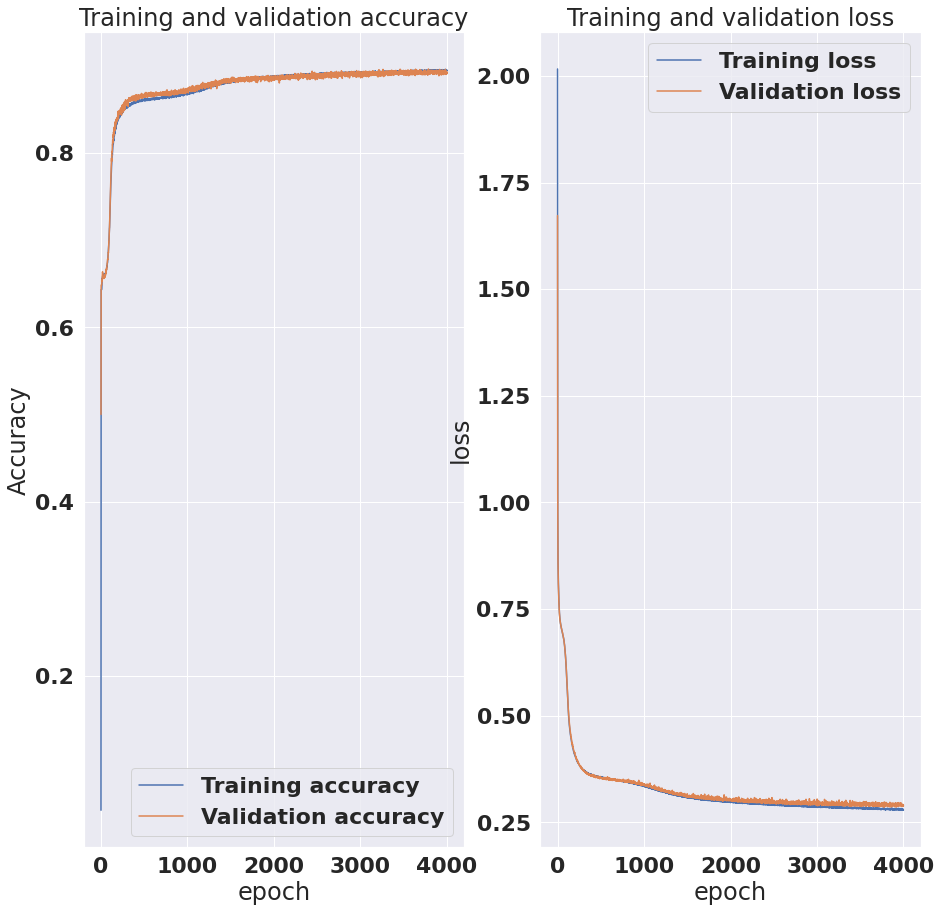

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(15,15))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

According to the plot of loss, validation loss is decreasing before the 2000th epoch, so the model
is underfitting. However, after the 2000th epoch, Validation loss converges to 0.28, indicating that the model is balanced. After the 2000th epoch, when the model is either perfectly fitted or in a local
minimum, the neural network model achieved an accuracy of 89%.
The goal of Deep Learning training is to find a balance between a model that is underfitting
and one that is overfitting(converging), resulting in a model with a good fit. I found an optimum where the
change in the slope of loss is around the 2000th epoch, as shown above. At that point, the training
process can be stopped. 


# Model 2: There are two hidden layers, each with 16 neurons and an activation function of sigmoid, epochs = 7000, and batch_size = 300

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax) 
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
model = get_basic_model()
history = model.fit(X_train, y_train, epochs=7000, validation_data=(X_test, y_test), batch_size=300) 

Streaming output truncated to the last 5000 lines.
58/58 [==============================] - 0s 5ms/step - loss: 0.1908 - accuracy: 0.9214 - val_loss: 0.2091 - val_accuracy: 0.9202
Epoch 4502/7000
58/58 [==============================] - 0s 5ms/step - loss: 0.1897 - accuracy: 0.9207 - val_loss: 0.2087 - val_accuracy: 0.9190
Epoch 4503/7000
58/58 [==============================] - 0s 4ms/step - loss: 0.1907 - accuracy: 0.9217 - val_loss: 0.2121 - val_accuracy: 0.9192
Epoch 4504/7000
58/58 [==============================] - 0s 4ms/step - loss: 0.1914 - accuracy: 0.9209 - val_loss: 0.2083 - val_accuracy: 0.9192
Epoch 4505/7000
58/58 [==============================] - 0s 5ms/step - loss: 0.1911 - accuracy: 0.9217 - val_loss: 0.2091 - val_accuracy: 0.9190
Epoch 4506/7000
58/58 [==============================] - 0s 5ms/step - loss: 0.1901 - accuracy: 0.9219 - val_loss: 0.2121 - val_accuracy: 0.9181
Epoch 4507/7000
58/58 [==============================] - 0s 5ms/step - loss: 0.1908 - accuracy:

136/136 - 0s - loss: 0.2167 - accuracy: 0.9188 - 186ms/epoch - 1ms/step


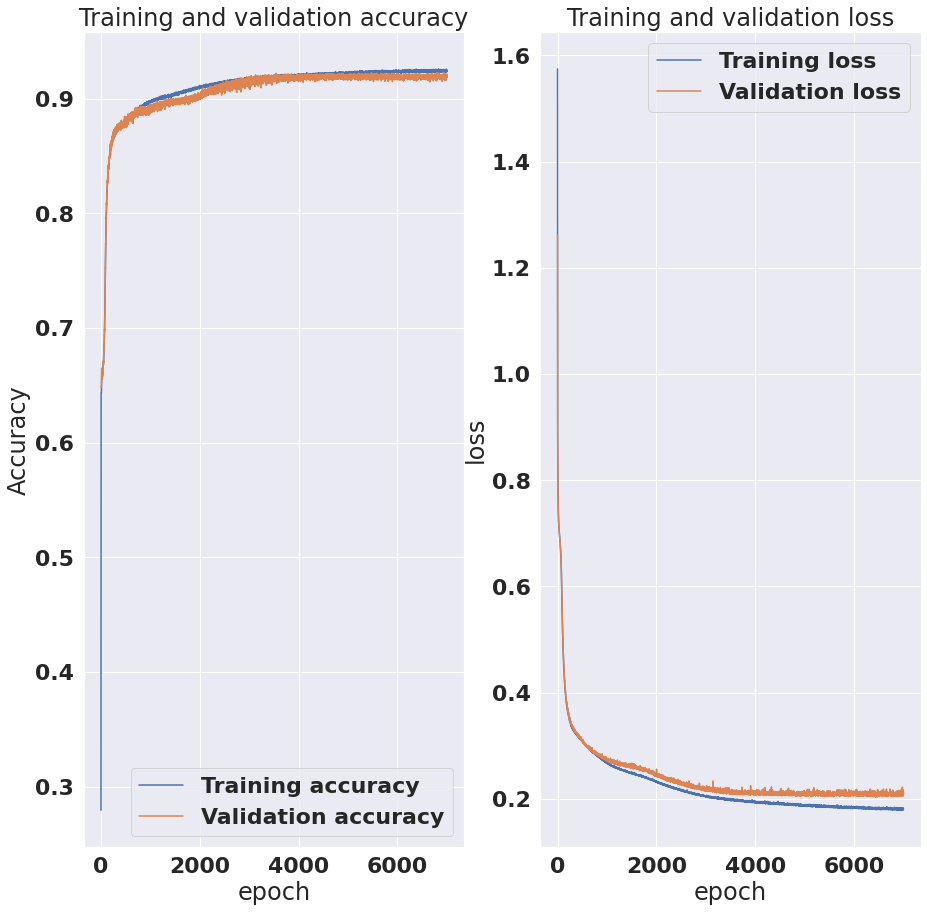

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(15,15))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

According to the plot of loss, validation loss is decreasing before the 4000th epoch, so the model
is underfitting. However, after the 4000th epoch, Validation loss converges to 0.2, indicating that the model is balanced. After the 4000th epoch, when the model is either perfectly fitted or in a local
minimum, the neural network model achieved an accuracy of 92%.
I found an optimum where the
change in the slope of loss is around the 4000th epoch, as shown above. At that point, the training
process can be stopped. 

# Final words

In terms of the number of hidden layers and neurons and their activation function, Model 1 and Model 2 are similar. However, by increasing the batch_size and epochs, which give the model more time to train, the accuracy has increased by 3%. To achieve high accuracy, it is sometimes better to test different batch_sizes for a model than to use complicated structures.